# The Finite Element Mesh


The finite element mesh is a fundamental construct for Underworld modelling. It will generally determine your domain geometry, and the resolution of the finite element system. For parallel simulations, the mesh topology will also determine the domain decomposition for the problem. Currently `underworld` only provides curvilinear mesh capabilities.

#### Overview:

1. Creating mesh objects.
1. Element types.
1. Deforming the mesh.
1. Saving and loading the mesh.
1. Special sets.

## Creating the mesh

First create an 2x2 element mesh. By default the mesh will be of rectangular geometry, with domain extents specified via the `minCoord` and `maxCoord` constructor parameters. 


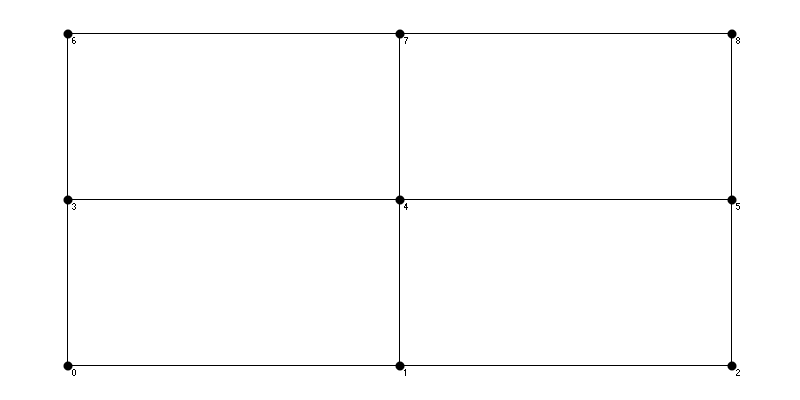

In [1]:
import underworld as uw
import glucifer
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (2, 2), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0) )

# visualising the result
figMesh = glucifer.Figure(figsize=(800,400))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True, pointsize=10) )
figMesh.show()

Mesh node location data is available as `numpy` arrays via the `data` mesh instances attribute:

In [2]:
for item in mesh.data:
    print(item)

[ 0.  0.]
[ 1.  0.]
[ 2.  0.]
[ 0.   0.5]
[ 1.   0.5]
[ 2.   0.5]
[ 0.  1.]
[ 1.  1.]
[ 2.  1.]


Note that data in `underworld` is always published as arrays of shape `(num_items, count)`, where `num_items` is the number of items in the dataset (in this case, 3x3 nodes, so `9`), and `count` is the size of each data item (so `1` for scalar data, `2` or `3` for vectors in 2- and 3-dimensions respectively, etc). 

In parallel, each process will be assigned responsibility for a subsection of the domain, and as such the length (`num_items`) of the arrays will generally be different across processes. As such, while it might be tempting to use `numpy.reshape` to reshape your arrays to reflect the cartesian mesh topology, this approach will **not** work in parallel and is therefore not usually recommended. You should instead traverse data arrays as 1-d lists (each item of size `count`). Following this pattern will usually result in models which can safely be run in serial or parallel. 

## Element Types
Underworld supports two primary element types: a linear element type (`Q1`) and a quadratic element type (`Q2`). Interpolation using these element types will provide continuous results across element boundaries, though note that interpolant derivatives will be discontinous across boundaries. Underworld also supports *mixed* element types, where a secondary element type may also be specified. This formulation is critical for stable solutions to Stokes type problems, with velocity fields being represented by the primary element type, and pressure fields by the secondary type. Secondary element types are not continuous across element boundaries. Supported secondary types are constant (`dQ0`), linear (`dPc1`) and bilinear (`dQ1`). Refer to http://femtable.org for further details on element types. 

Mesh element types are specified as a textual argument to the `elementType` constructor parameter. A primary type must always be provided (`Q1` or `Q2`), and where a secondary type is required, the primary/secondary types are provided as a pair (`Q1/dQ0`, `Q2/dPc1` or `Q2/dQ1`). For mixed type elements, two mesh objects are generated by the constructor, one for the primary and one for the secondary elements. The primary mesh will be the object returned directly by the constructor, with the secondary mesh available via the primary mesh's `subMesh` attribute:

In [3]:
pmesh = uw.mesh.FeMesh_Cartesian( elementType="Q2/dpc1" )
smesh = pmesh.subMesh
print("{}: primary node count \n{}: secondary node count".format(len(pmesh.data),len(smesh.data)))

81: primary node count 
48: secondary node count


Note that where constructor parameters are omitted, default values are used. For example, here a 4x4 mesh is generated because `elementRes` is not specified. Defaults values are baked into the `underworld` API and may be determined in Jupyter by pressing `shift`-`tab` with the cursor inside the constructor parenthesis, or by using the Python `help()` function (with the class/function of interest as the argument). Default values are useful for quickly mocking up models, but may change without notice so should not be relied upon. 

Element boundaries (and therefore domain geometry and resolution) is entirely determined by the primary mesh, with the location of the secondary mesh nodes slaved to the primary mesh nodes. Secondary mesh nodes are visualised below.


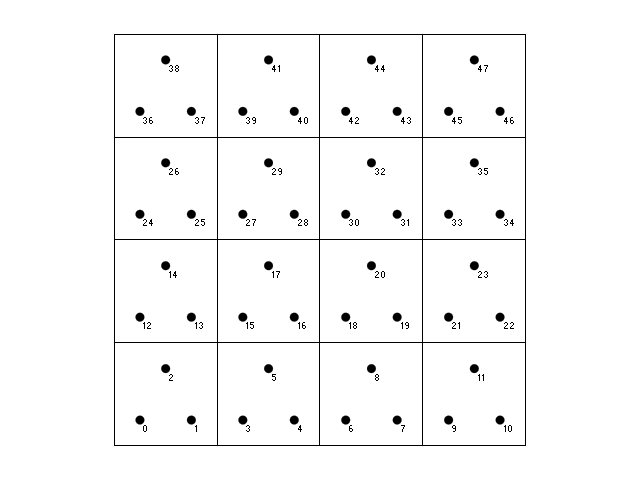

In [4]:
figMesh2 = glucifer.Figure()
figMesh2.append( glucifer.objects.Mesh(pmesh) )
figMesh2.append( glucifer.objects.Mesh(smesh, nodeNumbers=True, pointsize=10) )
figMesh2.show()

## Deforming the mesh

It is often desirable to deform the mesh to either conform the domain to some geometry, or to implement mesh refinement by bunching nodes in certain domain regions. The user is free to modify the mesh as desired, though care must be taken to ensure elements are not improperly transformed (Jacobians should not become singular) and to avoid tangling (face normals should be consistent). 

To deform the mesh, the user will directly modify the node coordinates via the usual `data` array. Note however that modifications are only possible from within the `deform_mesh()` context manager, as otherwise the array is read-only.


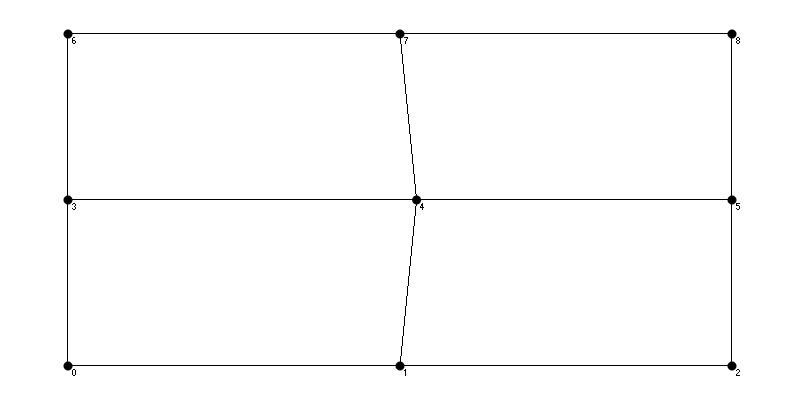

In [5]:
with mesh.deform_mesh():
    mesh.data[4][0] += 0.05
figMesh.show()

Note that in the above example, for simplicity, we've simply moved an arbitrary mesh node. Usually you will not want to construct your logic in ways which rely on the node numbers themselves, as this will usually not be consistent across parallel simulations, and/or as you vary model resolution.

We now look at a more realistic example where we deform the mesh to increase the resolution at the top of the domain. There are countless ways this may be achieved, but here we use the simple transformation $z \rightarrow \sqrt{z}$:


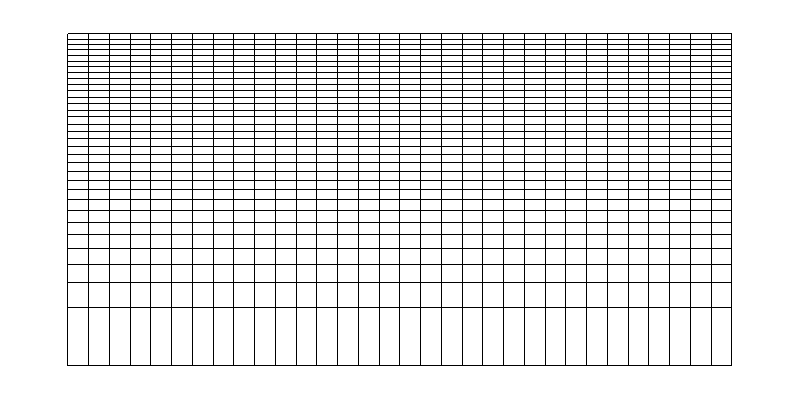

In [6]:
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32),maxCoord=(2.0,1.0))
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
        mesh.data[index][1] = mesh.data[index][1]**0.5
figMesh3 = glucifer.Figure(figsize=(800,400))
figMesh3.append(glucifer.objects.Mesh(mesh))
figMesh3.show()

## Saving and loading the mesh


Mesh coordinate data can be saved in hdf5 format using the mesh instance ``save`` method:

In [7]:
ignore = mesh.save('deformedMesh.h5')

To check that this has worked we will reset the mesh, visualise, then load the saved data and visualise again:


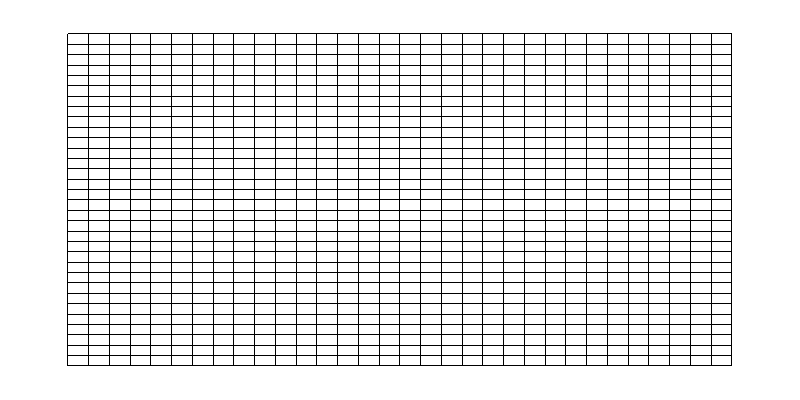

In [8]:
mesh.reset()
figMesh3.show()

Now re-load and display:


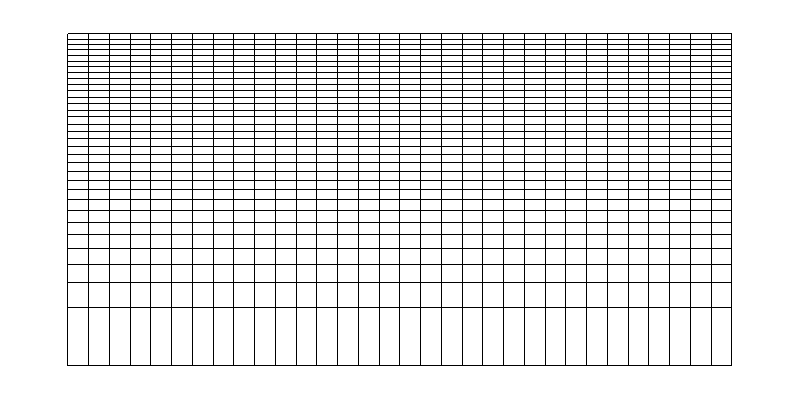

In [9]:
mesh.load('deformedMesh.h5')
figMesh3.show()

If you are resuming a simulation, you will usually need to reload the previous state of your simulation. In Underworld, the pattern is always to first *recreate* vanilla equivalent objects, and *then* reload the data. So in the case of the mesh above, you must first recreate a standard mesh object, and it must be of identical resolution and element type. Finally you will reload the data.

In [10]:
restartMesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32))
restartMesh.load('deformedMesh.h5')
import numpy as np
result = np.allclose(mesh.data,restartMesh.data)

# if this didn't work correctly, let's raise an error to alert the user.
if result==False:
    raise RuntimeError("Restarted mesh is not identical to original mesh.")
    
# let's remove the saved file as it is no longer required. 
if uw.rank()==0:
    import os;
    os.remove('deformedMesh.h5')

## Special sets


Special sets are sets of nodes which are in some way special to a given mesh object. For instance, for the cartesian mesh you will often wish to tie special values to the walls to form your problem boundary conditions. The list of special sets is provided via the `specialSets` list object:

In [11]:
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(2,2))
mesh.specialSets.keys()

['MaxI_VertexSet',
 'Top_VertexSet',
 'Left_VertexSet',
 'MinI_VertexSet',
 'AllWalls_VertexSet',
 'Bottom_VertexSet',
 'Right_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

The sets are named with respect to the `(I,J,K)` cartesian indexing of the mesh, with the `I` index usually used for the horizontal (left/right), `J` for the vertical, and `K` for horizontal (front/back). Note that this is just a matter of convention, and you are free to chose how the cartesian coordinates map within your model. So, for example,  `MinI_VertexSet` specifies the set of nodes belonings to what we would normally consider to be the left wall, and similarly `MaxI_VertexSet` the right wall.  We now also provide the alias (`Left_VertexSet`, `Right_VertexSet`, etc) for the most common use case.

In [12]:
leftset = mesh.specialSets['MinI_VertexSet']
print(leftset)

FeMesh_IndexSet([0, 3, 6])


You can confirm that these are indeed the left nodes with reference to the mesh visualisation at the top of the page. Note that the special set indices always specify parallel **local** indices. In almost all instances, you will interact with only local data and identifiers. This pattern is critical to successful parallel operation, and is usually a natural way of constructing your models. You should also note that the above visualisation shows the global node numbering, though for these serial demonstrations the values are identical. Your checkpointed mesh (and mesh variable) data will however be ordered according to its global numbering. If for some reason you need to determine the global identifiers, they are stored in the `data_elgId` array.

An important shorthand for your modelling is to use the special sets directly to index into arrays. For instance, we can find the coordinates of all left wall nodes directly as follows:

In [13]:
mesh.data[leftset]

array([[ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0. ,  1. ]])